In [509]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [510]:
# --- Standard library ---
import os
import sys
import time

# --- Scientific / data ---
import numpy as np
import pandas as pd
from scipy.sparse import csc_matrix

# --- Plotting ---
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm, Normalize
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.5

# --- Local modules ---
import pcms.haar
import pcms.stats
import pcms.tree
import utils

In [511]:
DATA = os.environ['DATA']
GN_DATA = os.path.join(DATA, 'guerrero_negro/')
GG_DATA = os.path.join(DATA, 'greengenes/gg_13_8_otus')
GG_TREES = os.path.join(GG_DATA, 'trees')
GG_OTU_MAPS = os.path.join(GG_DATA, 'otus')

## Part 1: Predicting the Proportion of OTUs Unrepresented in the Sample

In [512]:
env_A = '1200.GN09P.o'
env_B = '1200.GN01P.o'

### Load 97% Greengenes Reference Phylogeny

In [513]:
tree = pcms.tree.nwk2tree(os.path.join(GG_TREES, '97_otus.nwk'), ensure_planted=True)
n_leaves = tree.find_n_leaves()
seq_id2leaf_idx = utils.build_gg_seq_id2leaf_idx_map(tree)

In [514]:
intr_nodes = tree.find_interior_nodes()
tax_filepath = os.path.join(GG_DATA, 'taxonomy/97_otu_taxonomy.txt')

In [515]:
edge_lengths = tree.get_edge_length()
min_edge_length = np.min(edge_lengths[edge_lengths != 0])
print(f"Enforced minimum edge lenght: {min_edge_length}")

for node in range(tree.n_nodes):
    tree.set_edge_length(node, max(min_edge_length, tree.get_edge_length(node)))

Enforced minimum edge lenght: 0.0001


### Load Guerrero Negro Microbial Mat Dataset

In [516]:
gn_table_filepath = os.path.join(GN_DATA, "Harris et al. (2013)/454/47908_otu_table.tsv")
gn_table_df = utils.load_seq_id_abundances_from_biom_tsv(gn_table_filepath)

In [517]:
leaf_idxs = seq_id2leaf_idx[gn_table_df['OTU ID']].values
gn_table_df.loc[:, 'Leaf Index'] = leaf_idxs
gn_table_df.sort_values('Leaf Index', inplace=True, ignore_index=True)
gn_table_df.set_index('Leaf Index', inplace=True)

In [518]:
envs = ["1200.GN01P.o", "1200.GN02P.o", "1200.GN03P.o", "1200.GN04P.o", 
        "1200.GN05P.o", "1200.GN06P.o", "1200.GN07P.o", "1200.GN08P.o", 
        "1200.GN09P.o"]
gn_counts_df = gn_table_df.loc[(gn_table_df[envs] > 0).any(axis=1), envs]

In [520]:
total_counts = gn_counts_df.sum()
print(total_counts, '\n')

1200.GN01P.o    1814
1200.GN02P.o    1662
1200.GN03P.o    1369
1200.GN04P.o    1300
1200.GN05P.o    1054
1200.GN06P.o    1129
1200.GN07P.o    1423
1200.GN08P.o    1086
1200.GN09P.o    1012
dtype: int64 



In [521]:
def build_gn_rel_abund_df(gn_counts_df, residual_all=True):
    cols = gn_counts_df.columns
    gn_rel_abund_df = gn_counts_df.copy()
    gn_rel_abund_df[cols] = gn_counts_df[cols].div(gn_counts_df[cols].sum(axis=0), axis=1)

    tot_counts = gn_counts_df.sum()
    num_ones = (gn_counts_df == 1).sum()
    if residual_all:
        num_nonzero = (gn_counts_df != 0).sum()
        num_zeros = n_leaves - num_nonzero
    else:
        num_zeros = (gn_counts_df == 0).sum()

    coverage = 1 - num_ones / tot_counts
    residual = (1 - coverage) / num_zeros

    gn_rel_abund_df = gn_rel_abund_df.mul(coverage, axis=1)
    if residual_all:
        full_index = pd.Index(range(1, n_leaves + 1))
        gn_rel_abund_df = gn_rel_abund_df.reindex(full_index, fill_value=0)
    gn_rel_abund_df = gn_rel_abund_df.mask(gn_rel_abund_df == 0, residual, axis=1)
    if not residual_all:
        full_index = pd.Index(range(1, n_leaves + 1))
        gn_rel_abund_df = gn_rel_abund_df.reindex(full_index, fill_value=0)

    return gn_rel_abund_df, coverage, residual

In [522]:
gn_rel_abund_df, coverage, residual = build_gn_rel_abund_df(gn_counts_df, residual_all=True)

In [523]:
print(coverage,'\n')
print(residual)

1200.GN01P.o    0.888644
1200.GN02P.o    0.863418
1200.GN03P.o    0.859752
1200.GN04P.o    0.866154
1200.GN05P.o    0.882353
1200.GN06P.o    0.891054
1200.GN07P.o    0.882642
1200.GN08P.o    0.874770
1200.GN09P.o    0.887352
dtype: float64 

1200.GN01P.o    0.000001
1200.GN02P.o    0.000001
1200.GN03P.o    0.000001
1200.GN04P.o    0.000001
1200.GN05P.o    0.000001
1200.GN06P.o    0.000001
1200.GN07P.o    0.000001
1200.GN08P.o    0.000001
1200.GN09P.o    0.000001
dtype: float64


## Part 2: Haar-like Transform of Log-transformed Abundances

### Compute Haar-like Distance Components

In [526]:
gn_log_rel_abund_df = np.log10(gn_rel_abund_df)

In [528]:
Q, S = pcms.haar.sparsify(tree)

In [ ]:
a = gn_log_rel_abund_df[env_A]
b = gn_log_rel_abund_df[env_B]

In [530]:
haar_coords = Q.T @ (a - b)
haar_comps  = haar_coords**2 * S.diagonal()

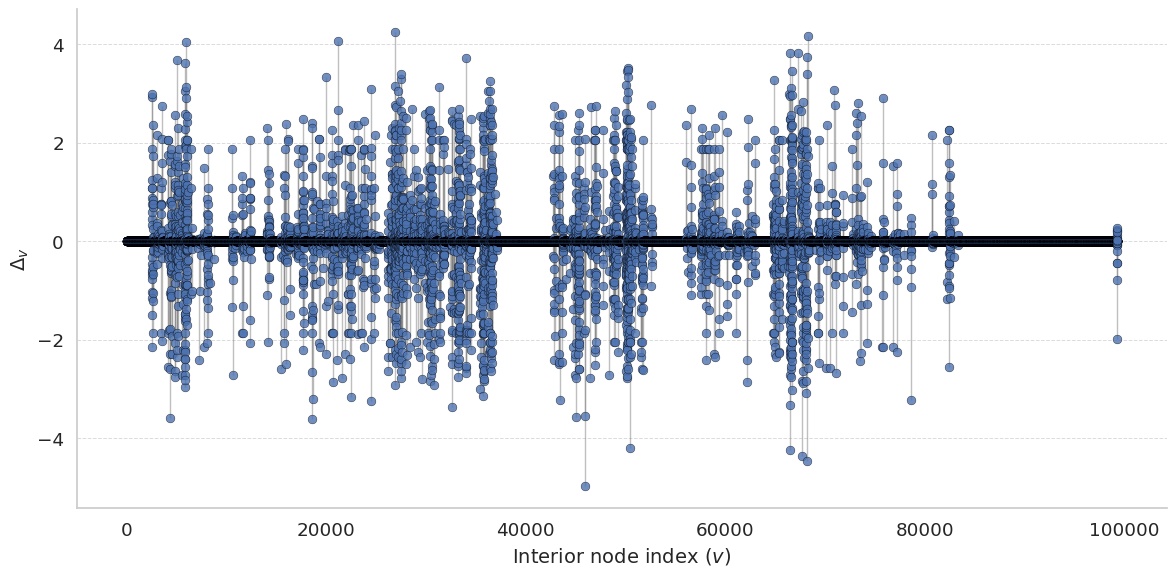

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

x = np.where(haar_coords)[0]
y = haar_coords[x]

utils.plot.haar_scatter(ax, x, y)

ax.set_xlabel('Interior node index ($v$)', fontsize=14)
ax.set_ylabel(r'$\Delta_v$', fontsize=14)

plt.tight_layout()
plt.show()

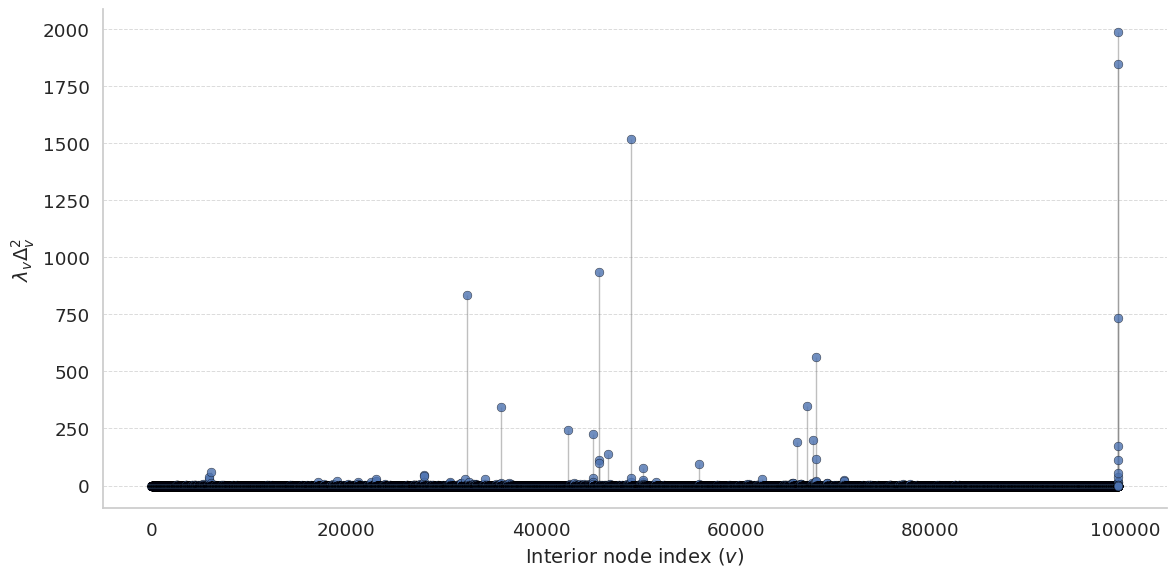

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

x = np.where(haar_comps)[0]
y = haar_comps[x]

utils.plot.haar_scatter(ax, x, y)

ax.set_xlabel('Interior node index ($v$)', fontsize=14)
ax.set_ylabel(r'$\lambda_v \Delta_v^2$', fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
sort_idx = np.argsort(haar_comps)[::-1]
print(sort_idx[:6])

### Taxonomic Classification of Splits of Dominant Haar-components

In [533]:
def tax_of_split(tree, idx, a_abunds, b_abunds = None):
    intr_nodes = tree.find_interior_nodes()
    tax_map_left  = utils.build_gg_otu_id2tax_map(tree, tax_filepath, 
                                                  node=tree.get_child(intr_nodes[idx]), 
                                                  a_abunds=a_abunds, b_abunds=b_abunds)
    tax_map_right = utils.build_gg_otu_id2tax_map(tree, tax_filepath, 
                                                  node=tree.get_sibling(tree.get_child(intr_nodes[idx])), 
                                                  a_abunds=a_abunds, b_abunds=b_abunds)
    return tax_map_left, tax_map_right


def truncate_lcr(lcr: str, max_ranks: int = 3) -> str:
    ranks = lcr.split(';')
    if len(ranks) > max_ranks:
        return ''.join(ranks[-max_ranks:])
    else:
        return lcr


def build_tax_table(tree, idxs, a_abunds, b_abunds, max_ranks=1):
    results = []

    for idx in idxs:
        left, right = tax_of_split(tree, idx, a_abunds, b_abunds)
        results.append({
            "node": idx,
            "left": {
                "lcr": truncate_lcr(left['lcr'], max_ranks),
                "values": [
                    {
                        "taxon": tax.strip(),
                        "otu_frac": row.otu_fracs,
                        "abund_frac": np.log10(row.a_abund_fracs / row.b_abund_fracs)
                    }
                    for tax, row in left['fracs'].iterrows()
                    if round(row.otu_fracs, 2) > 0.0
                ]
            },
            "right": {
                "lcr": truncate_lcr(right['lcr'], max_ranks),
                "values": [
                    {
                        "taxon": tax.strip(),
                        "otu_frac": row.otu_fracs,
                        "abund_frac": np.log10(row.a_abund_fracs / row.b_abund_fracs)
                    }
                    for tax, row in right['fracs'].iterrows()
                    if round(row.otu_fracs, 2) > 0.0
                ]
            }
        })

    return results

In [534]:
N = 12
gn_results = build_tax_table(tree, sort_idx[1:N+1], 
                             a_abunds=gn_rel_abund_df[env_A], 
                             b_abunds=gn_rel_abund_df[env_B])

In [535]:
def plot_split(ax, split_data, min_frac=1e-3, full_height=0.6):
    # Load data
    left_df = pd.DataFrame(split_data["left"]["values"])
    right_df = pd.DataFrame(split_data["right"]["values"])

    # Strip whitespace
    left_df["taxon"] = left_df["taxon"].str.strip()
    right_df["taxon"] = right_df["taxon"].str.strip()

    # Filter out small abundances
    left_df = left_df[np.abs(left_df["abund_frac"]) >= min_frac].copy()
    right_df = right_df[np.abs(right_df["abund_frac"]) >= min_frac].copy()

    # Max absolute value for x-scale
    max_abs = max(left_df["abund_frac"].abs().max() if not left_df.empty else 0,
                  right_df["abund_frac"].abs().max() if not right_df.empty else 0)

    pick_color = lambda x: "#2166ac" if x > 0 else "#b30c20"

    # Sort each subtree independently
    left_df_sorted = left_df.sort_values("abund_frac")
    right_df_sorted = right_df.sort_values("abund_frac")

    # Assign y positions separately
    left_y = np.arange(len(left_df_sorted))
    right_y = np.arange(len(right_df_sorted))

    # Plot left bars
    for i, row in enumerate(left_df_sorted.itertuples()):
        ax.barh(
            left_y[i],
            row.abund_frac,
            color=pick_color(row.abund_frac),
            edgecolor="black",
            height=full_height
        )
    
    # Divider line for left tree
    y0 = len(left_df_sorted) - 0.5
    if not left_df_sorted.empty:
        ax.axhline(y0, color='gray', linestyle='--', linewidth=2)

    # Plot right bars
    for i, row in enumerate(right_df_sorted.itertuples()):
        ax.barh(
            right_y[i] + len(left_y),  # offset so right bars are below left bars
            row.abund_frac,
            color=pick_color(row.abund_frac),
            edgecolor="black",
            height=full_height
        )

    # Center line at 0
    ax.axvline(0, color="black", linewidth=0.8)

    # Y-axis labels (concatenate left + right taxa)
    ax.set_yticks(np.arange(len(left_y) + len(right_y)))
    ax.set_yticklabels(list(left_df_sorted["taxon"]) + list(right_df_sorted["taxon"]))

    ax.set_xlim(-max_abs - 0.1, max_abs + 0.1)

In [536]:
def rename_unclassified(results):
    for node in results:
        for side in ["left", "right"]:
            for abund in node[side]["values"]:
                tax = abund["taxon"].strip()
                if tax.endswith("__"):
                    prefix = tax[:3]  # e.g., "c__" or "p__"
                    abund["taxon"] = f"{prefix}Unclassified"

In [537]:
rename_unclassified(gn_results)

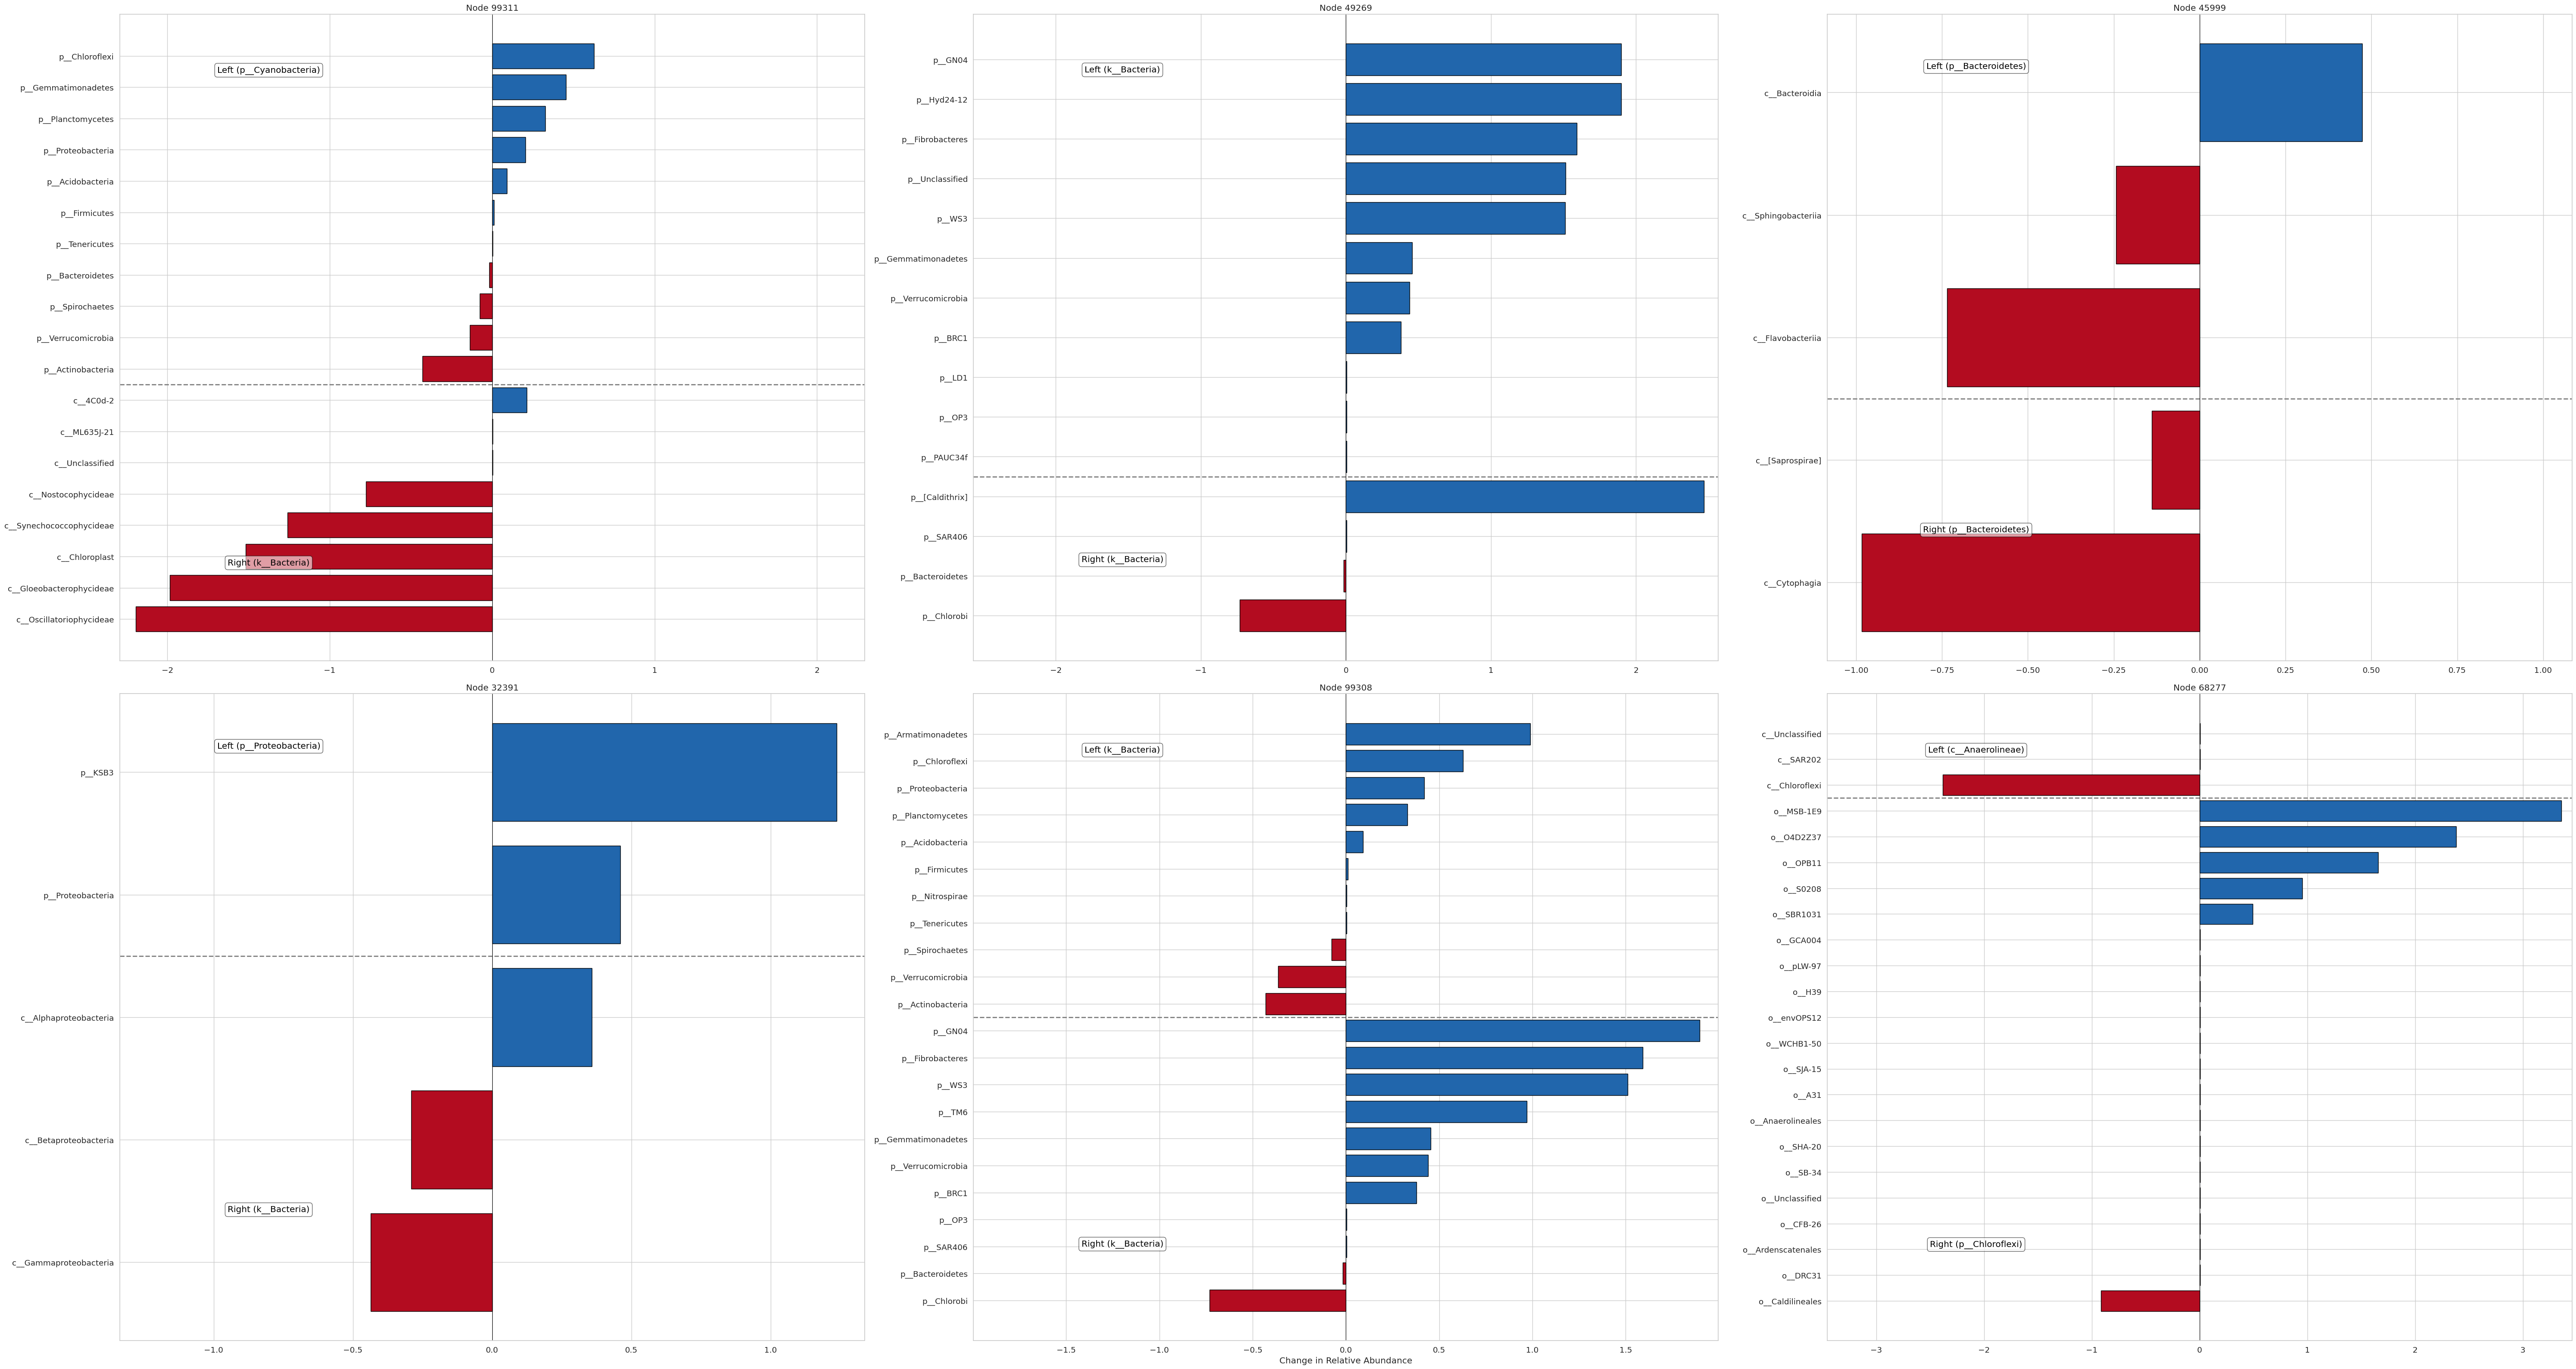

In [539]:
# Determine bar heights
full_height =  0.8
overlap_height = full_height * 2/3

# Plot
fig, axes = plt.subplots(2, 3, figsize=(60, 32))
axes = axes.flatten()

yshift0 = [0.9, 0.9, 0.9, 0.9, 0.9, 0.9]
yshift1 = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
xshift  = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2]

for i, ax in enumerate(axes[:6]):
    split_data = gn_results[i]

    # split plot
    plot_split(
        ax, split_data, min_frac=0.0, full_height=full_height
    )
    ax.set_title(f"Node {split_data['node']+1}")

    # text box
    y0 = yshift0[i] * ax.get_ylim()[1]
    y1 = yshift1[i] * ax.get_ylim()[1]
    x0 = ((1 - xshift[i]) * ax.get_xlim()[0] + xshift[i] * ax.get_xlim()[1])
    bbox_props = dict(boxstyle="round,pad=0.3", facecolor="white",
                      edgecolor="black", alpha=0.6)
    ax.text(x0, y0, f"Left ({split_data['left']['lcr'].strip()})", 
            ha='center', va='bottom', color='black', bbox=bbox_props)
    ax.text(x0, y1, f"Right ({split_data['right']['lcr'].strip()})", 
            ha='center', va='top', color='black', bbox=bbox_props)

# X-axis labels for bottom row
axes[-2].set_xlabel('Change in Relative Abundance')

plt.tight_layout()
plt.show()